In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

import MetaTrader5 as mt5 # для работы с торговой платформой

import threading # для многопоточности
import pickle # сохранение объектов

from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.metrics import make_scorer #создание метрики
from sklearn import model_selection #методы разделения и валидации

from prophet import Prophet
#from neuralprophet import NeuralProphet

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna # для оптимизации гиперпараметров
import pmdarima as pm # для автоматического подбора гиперпараметров

from statsmodels.tsa.arima.model import ARIMA # для модели ARIMA

import datetime as dt
from datetime import datetime

from tqdm import tqdm  # для отображения прогресса долгих рассчетов
tqdm.pandas()

from IPython.display import clear_output # для очистки вывода
import logging # для логирования
import random # для генерации случайных чисел
import winsound  # пищим динамиком, когда надо
import time

pd.options.mode.chained_assignment = None  # для подавления предупреждений

In [2]:
# зададим переменные
random_state = 42
symbol = "EURUSDrfd"
time_delta = 10 * 60 # 10 минут - время, которое нас интересует в качестве предсказания для пипсовой торговли
pips_delta = 0.00025 # 25 пипсов - минимальное изменение цены, которое нас интересует в качестве предсказания для пипсовой торговли (это мы вычислим позже)

In [3]:
# функция, что-бы попищать динамиком. Полезно, что-бы просигналить, что долгий рассчёт окончен

def beep():
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(round(frequency/4), duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(frequency, duration)

# 6. Ансамбль

А что если мы используем вывод модели Prophet в качестве параметров для другой модели, создав своего рода ансамбль?<br>
Тем более, что в таком случае мы можем добавить в нашу модель и baseline-модель.<br>
Таким образом на вход модели будут подаваться результаты предсказания baseline, плюс результаты работы модели Prophet

In [20]:
# загрузим результаты
df = pd.read_csv('df.csv')
# загрузим полные данные из файла с сервера
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target_solved.pkl')
# превратим колнку time в индекс
df.set_index('time', inplace=True)

In [42]:
# загрузим модель baseline
model_bl = pickle.load(open('pkl/model.pkl', 'rb'))
# загрузим данные из файла
X_bl = pd.read_pickle('pkl/X.pkl')
X_bl.drop(['ask','bid','time'], axis=1, inplace=True)

In [71]:
# добавим в датафрейм df bid и ask
df['bid'] = ticks_frame_target['bid']
df['ask'] = ticks_frame_target['ask']

Пересчитаем для каждой точки датафрейма df предсказания вероятностей от baseline модели

In [66]:
df['class_m1'] = 0
df['class_0'] = 0
df['class_1'] = 0

results_m1 = np.zeros(len(df))
results_0 = np.zeros(len(df))
results_1 = np.zeros(len(df))

for i in tqdm(range(len(df))):
    start = df.index[i]
    proba = model_bl.predict_proba(X_bl.loc[start:start])
    class_m1 = proba[0][0]
    class_0 = proba[0][1]
    class_1 = proba[0][2]
    # запишем результаты в results
    results_m1[i] = class_m1
    results_0[i] = class_0
    results_1[i] = class_1   
    
# запишем результаты в датафрейм 
df['class_m1'] = results_m1
df['class_0'] = results_0
df['class_1'] = results_1


100%|██████████| 50526/50526 [44:56<00:00, 18.74it/s]  


In [68]:
df.head(3)

,signal,ask_yhat,ask_yhat_lower,ask_yhat_upper,bid_yhat,bid_yhat_lower,bid_yhat_upper,ask_real,bid_real,error,light_signal,class_m1,class_0,class_1
time,,,,,,,,,,,,,,
2023-10-02 04:00:39,0,1.056433,1.055716,1.057073,1.056293,1.055744,1.056928,1.05680,1.05666,-0.000367,1,0.183959,0.673353,0.142688
2023-10-02 04:02:29,0,1.056480,1.055835,1.057054,1.056341,1.055709,1.056932,1.05685,1.05671,-0.000369,1,0.242586,0.533183,0.224231
2023-10-02 04:03:33,0,1.056501,1.055737,1.057239,1.056360,1.055722,1.057132,1.05674,1.05660,-0.000240,1,0.231719,0.576458,0.191822


Создадим наши наборы данных

In [72]:
X = df[['bid_yhat', 'bid_yhat_lower', 'bid_yhat_upper', 'ask_yhat', 'ask_yhat_lower', 'ask_yhat_upper', 'class_m1', 'class_0', 'class_1']]
y = df['signal']
y_light = df['light_signal']
X.head(3)

,bid_yhat,bid_yhat_lower,bid_yhat_upper,ask_yhat,ask_yhat_lower,ask_yhat_upper,class_m1,class_0,class_1
time,,,,,,,,,
2023-10-02 04:00:39,1.056293,1.055744,1.056928,1.056433,1.055716,1.057073,0.183959,0.673353,0.142688
2023-10-02 04:02:29,1.056341,1.055709,1.056932,1.056480,1.055835,1.057054,0.242586,0.533183,0.224231
2023-10-02 04:03:33,1.056360,1.055722,1.057132,1.056501,1.055737,1.057239,0.231719,0.576458,0.191822


In [74]:
# Поскольку модель Prophet выдаёт абсолютные значения, а не относительные, то нам нужно дифференцировать данные относительно текущего значения bid и ask
# для этого создадим новые колонки bid_diff и ask_diff
X['bid_diff'] = X['bid_yhat'] - df['bid']
X['ask_diff'] = X['ask_yhat'] - df['ask']
X['bid_diff_lower'] = X['bid_yhat_lower'] - df['bid']
X['ask_diff_lower'] = X['ask_yhat_lower'] - df['ask']
X['bid_diff_upper'] = X['bid_yhat_upper'] - df['bid']
X['ask_diff_upper'] = X['ask_yhat_upper'] - df['ask']

# удалим ненужные колонки
X.drop(['bid_yhat', 'ask_yhat', 'bid_yhat_lower', 'ask_yhat_lower', 'bid_yhat_upper', 'ask_yhat_upper'], axis=1, inplace=True)

X.head(3)

C:\Users\trigubov\AppData\Local\Temp\ipykernel_10604\2651611269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['bid_diff'] = X['bid_yhat'] - df['bid']
C:\Users\trigubov\AppData\Local\Temp\ipykernel_10604\2651611269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ask_diff'] = X['ask_yhat'] - df['ask']
C:\Users\trigubov\AppData\Local\Temp\ipykernel_10604\2651611269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,class_m1,class_0,class_1,bid_diff,ask_diff,bid_diff_lower,ask_diff_lower,bid_diff_upper,ask_diff_upper
time,,,,,,,,,
2023-10-02 04:00:39,0.183959,0.673353,0.142688,-0.000047,-0.000047,-0.000596,-0.000764,0.000589,0.000593
2023-10-02 04:02:29,0.242586,0.533183,0.224231,-0.000159,-0.000160,-0.000791,-0.000805,0.000432,0.000414
2023-10-02 04:03:33,0.231719,0.576458,0.191822,-0.000047,-0.000047,-0.000685,-0.000811,0.000725,0.000691


Итак, мы получили набор данных, в которых не содержится исходной инфомации, а только выводы предсказаний других моделей (baseline RandomForest и Prophet). Попробуем сделать результирующее предсказание, используя финальную модель. Я выбрал RandomForest

In [75]:
# сохраним наши X и y в файлы pickle
X.to_pickle('pkl/X_ensemble.pkl')
y.to_pickle('pkl/y_ensemble.pkl')
y_light.to_pickle('pkl/y_light_ensemble.pkl')


In [76]:
# загрузим данные из файла
X = pd.read_pickle('pkl/X_ensemble.pkl')
y = pd.read_pickle('pkl/y_ensemble.pkl')
y_light = pd.read_pickle('pkl/y_light_ensemble.pkl')

Разделим данные на тренировочные и тестовые

In [77]:
X.shape, y.shape, y_light.shape

((50526, 9), (50526,), (50526,))

In [79]:
X_train = X.loc['2023-10-01':'2023-10-21']
X_test = X.loc['2023-10-23':'2023-10-28']
y_train = y.loc['2023-10-01':'2023-10-21']
y_test = y.loc['2023-10-23':'2023-10-28']
y_light_train = y_light.loc['2023-10-01':'2023-10-21']
y_light_test = y_light.loc['2023-10-23':'2023-10-28']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (32986, 9)
Размер тестовой выборки: (8776, 9)


In [80]:
# проверим, что соотношение классов в обучающей и тестовой выборке примерно одинаковое
print('Соотношение классов в обучающей выборке:')
print(y_train.value_counts(normalize=True)*100)
print()
print('Соотношение классов в тестовой выборке:')
print(y_test.value_counts(normalize=True)*100)

Соотношение классов в обучающей выборке:
signal
 0    68.474504
 1    16.879888
-1    14.645607
Name: proportion, dtype: float64

Соотношение классов в тестовой выборке:
signal
 0    64.744758
 1    17.775752
-1    17.479490
Name: proportion, dtype: float64


Наконец, построим модель

In [108]:
model = ensemble.RandomForestClassifier(
    #n_estimators=128,
    #max_depth=5,
    #criterion='log_loss',
    #min_samples_leaf=90,
    random_state=random_state,
    #verbose=2,
    class_weight = {-1: 5, 0: 1, 1: 5}, # классы 1 и -1 для нас значимо более важны. Поэтому взвесим их выше
    n_jobs=-1
    )

In [109]:
model.fit(X_train, y_train)
    
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [110]:
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4831
           0       1.00      1.00      1.00     22587
           1       1.00      1.00      1.00      5568

    accuracy                           1.00     32986
   macro avg       1.00      1.00      1.00     32986
weighted avg       1.00      1.00      1.00     32986

              precision    recall  f1-score   support

          -1       0.29      0.24      0.26      1534
           0       0.75      0.88      0.81      5682
           1       0.45      0.25      0.32      1560

    accuracy                           0.66      8776
   macro avg       0.50      0.46      0.46      8776
weighted avg       0.62      0.66      0.63      8776



In [114]:
# сделаем аналогично для signal_light
model_l = ensemble.RandomForestClassifier(
    #n_estimators=128,
    #max_depth=5,
    #criterion='log_loss',
    #min_samples_leaf=90,
    random_state=random_state,
    #verbose=2,
    class_weight = {-1: 5, 0: 1, 1: 5}, # классы 1 и -1 для нас значимо более важны. Поэтому взвесим их выше
    n_jobs=-1
    )

model_l.fit(X_train, y_light_train)
    
y_test_pred = model_l.predict(X_test)
y_train_pred = model_l.predict(X_train)

print(metrics.classification_report(y_light_train, y_train_pred))
print(metrics.classification_report(y_light_test, y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      7359
           0       1.00      1.00      1.00     18127
           1       1.00      1.00      1.00      7500

    accuracy                           1.00     32986
   macro avg       1.00      1.00      1.00     32986
weighted avg       1.00      1.00      1.00     32986

              precision    recall  f1-score   support

          -1       0.35      0.35      0.35      2547
           0       0.54      0.69      0.61      3800
           1       0.36      0.21      0.26      2429

    accuracy                           0.46      8776
   macro avg       0.42      0.42      0.41      8776
weighted avg       0.44      0.46      0.44      8776



Без подобора гиперпараметров модель опять сильно переобучена. Запустим подбор гиперпараметров


## 6.1 Подбор гиперпараметров модели ансамбля

In [93]:
def my_custom_metric(y_true, y_pred_):
    
    # это метрики, которые я использовал для подбора параметров модели
    # это среднее значение метрик f1 для классов -1 и 1
    metr = (metrics.f1_score(y_true, y_pred_,labels=[-1],average='macro') + metrics.f1_score(y_true, y_pred_,labels=[1],average='macro')) / 2    
    
    return metr

score = make_scorer(my_custom_metric, greater_is_better=True)

In [94]:
# создадим функцию для подбора параметров модели

def objective(trial):

    params = {
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10, step=1),        
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=1),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        #'class_weight-1': trial.suggest_int('class_weight-1', 1, 10, step=1),
        'class_weight1': trial.suggest_int('class_weight1', 1, 10, step=1),
    }

    model = ensemble.RandomForestClassifier(
        min_samples_leaf=params['min_samples_leaf'],
        max_depth=params['max_depth'],        
        max_features=params['max_features'],
        n_estimators=params['n_estimators'],        
        criterion=params['criterion'],
        class_weight={-1:  params['class_weight1'], 0:1, 1:  params['class_weight1']},        
        random_state=random_state,
        n_jobs=-1
    )

    #model.fit(X_train, y_train)
    #y_pred_test = model.predict(X_test)
    #metr = (metrics.f1_score(y_test, y_pred_test,labels=[-1],average='macro') + metrics.f1_score(y_test, y_pred_test,labels=[1],average='macro')) / 2

    # используем метод кросс-валидации для подсчета метрики
    metr = model_selection.cross_val_score(model, X_train, y_train, cv=5, scoring=score, n_jobs=-1).mean()
    
    return metr #mean_squared_error(y_valid, model.predict(X_valid), squared=False)

In [137]:
# старт оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-11-29 17:05:52,465] A new study created in memory with name: no-name-33ff96aa-3067-4b08-b85e-e6819a20dc8d
[I 2023-11-29 17:06:13,812] Trial 0 finished with value: 0.3868755145460211 and parameters: {'min_samples_leaf': 243, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 477, 'criterion': 'gini', 'class_weight1': 4}. Best is trial 0 with value: 0.3868755145460211.
[I 2023-11-29 17:06:31,963] Trial 1 finished with value: 0.3816515156225599 and parameters: {'min_samples_leaf': 713, 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 356, 'criterion': 'entropy', 'class_weight1': 10}. Best is trial 0 with value: 0.3868755145460211.
[I 2023-11-29 17:06:38,617] Trial 2 finished with value: 0.3948836482980475 and parameters: {'min_samples_leaf': 1181, 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 171, 'criterion': 'log_loss', 'class_weight1': 4}. Best is trial 2 with value: 0.3948836482980475.
[I 2023-11-29 17:06:40,100] Trial 3 finished with value: 0.30508188066

KeyboardInterrupt: 

In [ ]:
# время есть. Еще чуть-чуть посчитаем.
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(objective, n_trials=200)

In [96]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'min_samples_leaf': 41, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 13, 'criterion': 'gini', 'class_weight1': 5}
f1_score на обучающем наборе: 0.40


Данная обработка запускалась на другом сервере. Вот её результаты:

Наилучшие значения гиперпараметров {'min_samples_leaf': 7, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 59, 'criterion': 'entropy', 'class_weight1': 3}
f1_score на обучающем наборе: 0.41

In [151]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(
        min_samples_leaf=7,
        max_depth=4,
        max_features='log2',
        n_estimators=59,
        criterion='entropy',        
        class_weight={-1: 3, 0: 1, 1: 3},
        n_jobs=-1,
        random_state=random_state
)    

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('---train---')
print(metrics.classification_report(y_train, y_train_pred))
print('---test---')
print(metrics.classification_report(y_test, y_test_pred))

---train---
              precision    recall  f1-score   support

          -1       0.32      0.34      0.33      4831
           0       0.92      0.80      0.86     22587
           1       0.44      0.65      0.53      5568

    accuracy                           0.71     32986
   macro avg       0.56      0.60      0.57     32986
weighted avg       0.75      0.71      0.73     32986

---test---
              precision    recall  f1-score   support

          -1       0.27      0.43      0.33      1534
           0       0.86      0.73      0.79      5682
           1       0.43      0.43      0.43      1560

    accuracy                           0.62      8776
   macro avg       0.52      0.53      0.52      8776
weighted avg       0.68      0.62      0.65      8776



In [165]:
# сохраним модель
pickle.dump(model, open('pkl/model_ensemble.pkl', 'wb'))

## Подбор порогового значения trashhold

  0%|          | 0/70 [00:00<?, ?it/s]

 51%|█████▏    | 36/70 [00:01<00:01, 22.06it/s]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|█████▌    | 39/70 [00:01<00:01, 21.79it/s]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to con

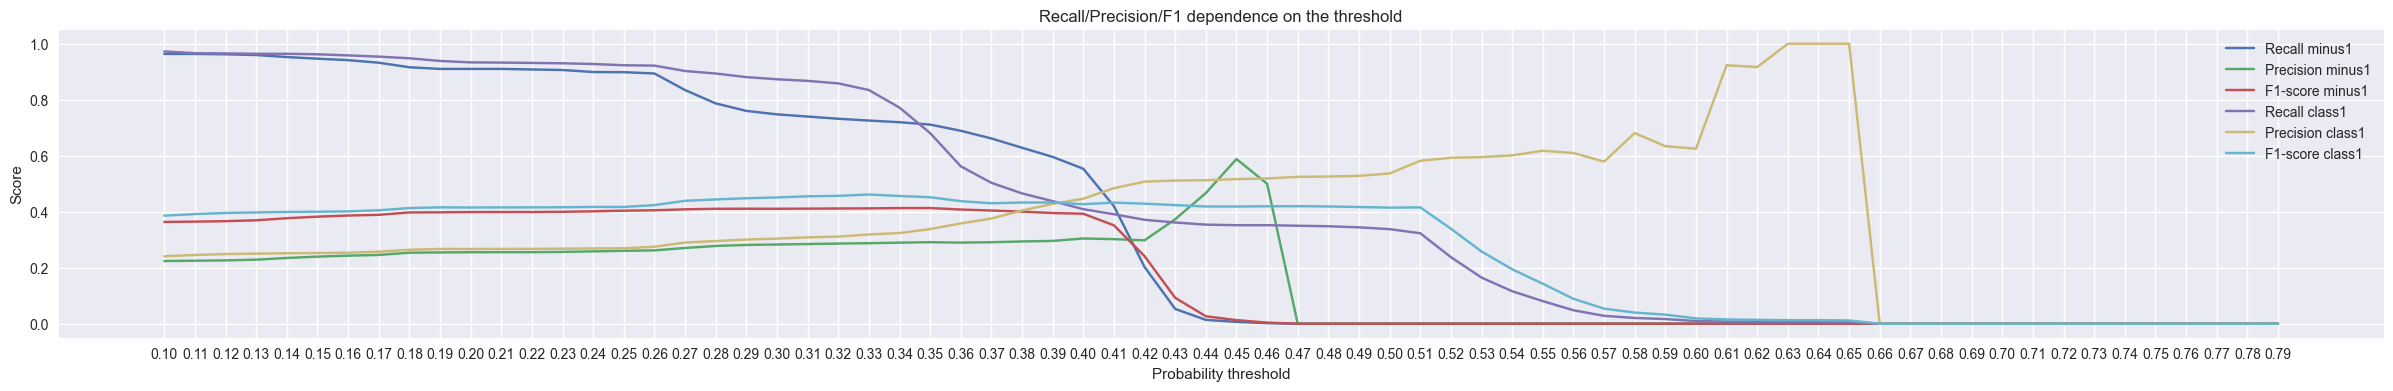

In [152]:
y_test_pred = model.predict(X_test)


# Ваш код здесь
y_valid_proba_pred_minus1 = pd.Series(model.predict_proba(X_test)[:, 0]) # вероятность класса -1
y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1]) # вероятность класса 0
y_valid_proba_pred_class1 = pd.Series(model.predict_proba(X_test)[:, 2]) # вероятность класса 1

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0) # класс 1
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0) # класс -1
y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0) # класс 0

# Инициализируем список, куда будем сохранять метрики.
scores_f1_class1 = []
scores_f1_minus1 = []
scores_f1_zero = []

scores_r_class1 = []
scores_r_minus1 = []
scores_r_zero = []

scores_p_class1 = []
scores_p_minus1 = []
scores_p_zero = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 0.8, 0.01)

# В цикле перебираем значения порогов вероятности

for threshold in tqdm(thresholds):
    # Делаем предсказание
    y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

    # Рассчитываем метрику
    score_f1_class1 = metrics.f1_score(y_valid_class1, y_test_pred_poly_class1)
    score_p_class1 = metrics.precision_score(y_valid_class1, y_test_pred_poly_class1)
    score_r_class1 = metrics.recall_score(y_valid_class1, y_test_pred_poly_class1)
    scores_f1_class1.append(score_f1_class1)
    scores_r_class1.append(score_r_class1)
    scores_p_class1.append(score_p_class1)

    score_f1_zero = metrics.f1_score(y_valid_zero, y_test_pred_poly_zero)
    score_p_zero = metrics.precision_score(y_valid_zero, y_test_pred_poly_zero)
    score_r_zero = metrics.recall_score(y_valid_zero, y_test_pred_poly_zero)
    scores_f1_zero.append(score_f1_zero)
    scores_r_zero.append(score_r_zero)
    scores_p_zero.append(score_p_zero)
    
    score_f1_minus1 = metrics.f1_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_p_minus1 = metrics.precision_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_r_minus1 = metrics.recall_score(y_valid_minus1, y_test_pred_poly_minus1)    
    scores_f1_minus1.append(score_f1_minus1)
    scores_r_minus1.append(score_r_minus1)
    scores_p_minus1.append(score_p_minus1)

#Визуализируем метрики при различных threshold

fig, ax = plt.subplots(figsize=(30, 4)) #фигура + координатная плоскость


# Что-бы не замусоривать график - выведем только класс 1, а остальное закомментируем


#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_minus1, label='Recall minus1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_minus1, label='Precision minus1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_minus1, label='F1-score minus1')

#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_class1, label='Recall class1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_class1, label='Precision class1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_class1, label='F1-score class1')

#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, scores_r_zero, label='Recall zero')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, scores_p_zero, label='Precision zero')
#Строим линейный график зависимости F1 от threshold
#ax.plot(thresholds, scores_f1_zero, label='F1-score zero')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Что-ж. 0.6 точность предсказания нас устраивает. Дальнейший "прыжок" точности до 100% - происходит при крайне малом охвате.

In [159]:
threshold_class1 = 0.51 # выберем порог 0.51 для класса 1
threshold_class_minus1 = 0.42 # выберем порог 0.42 для класса -1. Почему-то класс -1 определяется моделью плохо


# сделаем предсказание на тестовой выборке, учитывая порог
y_valid_proba_pred_minus1 = pd.Series(model.predict_proba(X_test)[:, 0])
#y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1])
y_valid_proba_pred_class1 = pd.Series(model.predict_proba(X_test)[:, 2])

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0)
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0)
#y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0)

y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold_class1 else 0)
y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold_class_minus1 else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

#y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

y_test_pred = y_test_pred_poly_class1 + y_test_pred_poly_minus1 * -1

# выведем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.30      0.20      0.24      1534
           0       0.74      0.89      0.81      5682
           1       0.58      0.32      0.42      1560

    accuracy                           0.67      8776
   macro avg       0.54      0.47      0.49      8776
weighted avg       0.63      0.67      0.64      8776



Посмотрим, как поведут себя метрики, если вместо целевого сигнала используем "облегченный"

In [160]:
# выведем метрики
print(metrics.classification_report(y_light_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.38      0.16      0.22      2547
           0       0.49      0.89      0.63      3800
           1       0.54      0.19      0.28      2429

    accuracy                           0.48      8776
   macro avg       0.47      0.41      0.38      8776
weighted avg       0.47      0.48      0.41      8776



Точность упала. По всей видимости это вызвано тем, что на некоторых сигналах за 10 минут курс успевал упасть от достигнутого порогового значения и стать убыточным

Попробуем обучить модель на "облегченном" сигнале

In [161]:
# сделаем аналогично для signal_light
model_l = ensemble.RandomForestClassifier(
    #n_estimators=128,
    max_depth=4,
    #criterion='log_loss',
    #min_samples_leaf=90,
    random_state=random_state,
    #verbose=2,
    class_weight = {-1: 3, 0: 1, 1: 3}, # классы 1 и -1 для нас значимо более важны. Поэтому взвесим их выше
    n_jobs=-1
    )

model_l.fit(X_train, y_light_train)
    
y_test_pred = model_l.predict(X_test)
y_train_pred = model_l.predict(X_train)

print(metrics.classification_report(y_light_train, y_train_pred))
print(metrics.classification_report(y_light_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.32      0.58      0.42      7359
           0       0.91      0.60      0.72     18127
           1       0.44      0.46      0.45      7500

    accuracy                           0.56     32986
   macro avg       0.56      0.55      0.53     32986
weighted avg       0.67      0.56      0.59     32986

              precision    recall  f1-score   support

          -1       0.33      0.73      0.46      2547
           0       0.75      0.39      0.51      3800
           1       0.44      0.23      0.30      2429

    accuracy                           0.44      8776
   macro avg       0.51      0.45      0.42      8776
weighted avg       0.55      0.44      0.44      8776



  0%|          | 0/70 [00:00<?, ?it/s]

 60%|██████    | 42/70 [00:01<00:01, 26.24it/s]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 64%|██████▍   | 45/70 [00:01<00:00, 25.86it/s]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to con

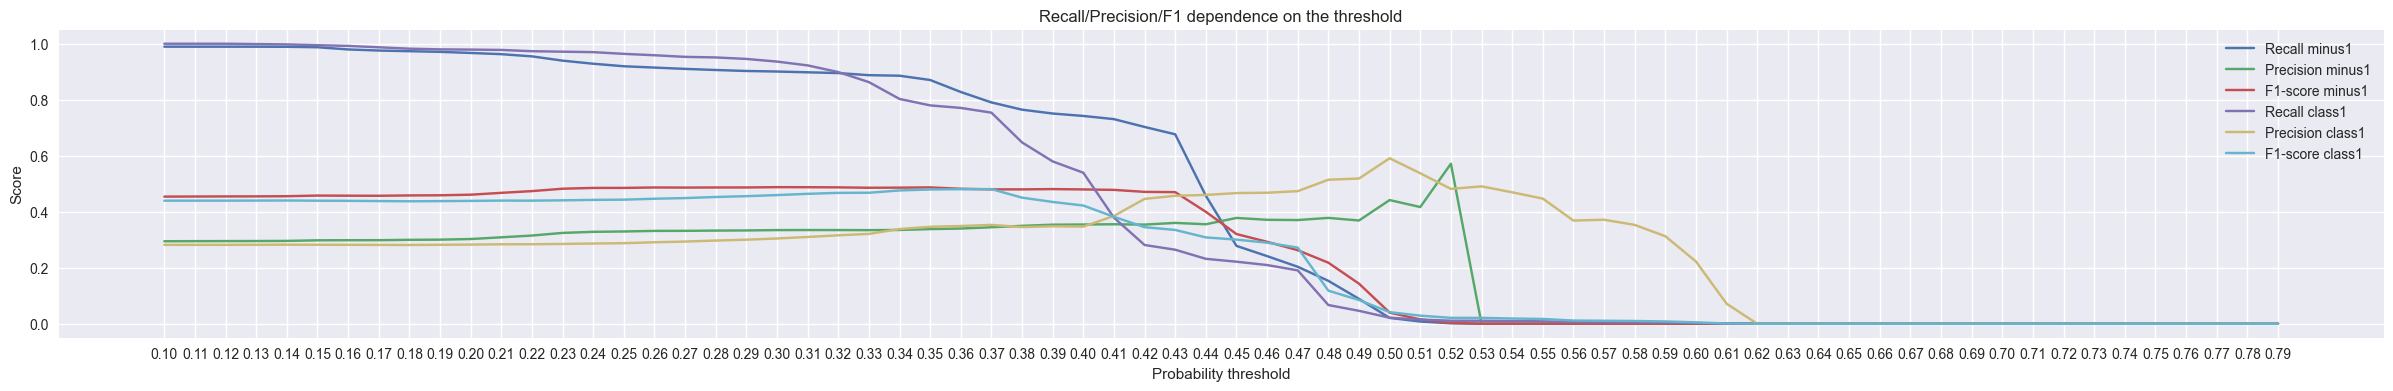

In [162]:
y_test_pred = model_l.predict(X_test)


# Ваш код здесь
y_valid_proba_pred_minus1 = pd.Series(model_l.predict_proba(X_test)[:, 0]) # вероятность класса -1
y_valid_proba_pred_zero = pd.Series(model_l.predict_proba(X_test)[:, 1]) # вероятность класса 0
y_valid_proba_pred_class1 = pd.Series(model_l.predict_proba(X_test)[:, 2]) # вероятность класса 1

y_valid_class1 = y_light_test.apply(lambda x: 1 if x>0 else 0) # класс 1
y_valid_minus1 = y_light_test.apply(lambda x: 1 if x<0 else 0) # класс -1
y_valid_zero = y_light_test.apply(lambda x: 1 if x==0 else 0) # класс 0

# Инициализируем список, куда будем сохранять метрики.
scores_f1_class1 = []
scores_f1_minus1 = []
scores_f1_zero = []

scores_r_class1 = []
scores_r_minus1 = []
scores_r_zero = []

scores_p_class1 = []
scores_p_minus1 = []
scores_p_zero = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 0.8, 0.01)

# В цикле перебираем значения порогов вероятности

for threshold in tqdm(thresholds):
    # Делаем предсказание
    y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

    # Рассчитываем метрику
    score_f1_class1 = metrics.f1_score(y_valid_class1, y_test_pred_poly_class1)
    score_p_class1 = metrics.precision_score(y_valid_class1, y_test_pred_poly_class1)
    score_r_class1 = metrics.recall_score(y_valid_class1, y_test_pred_poly_class1)
    scores_f1_class1.append(score_f1_class1)
    scores_r_class1.append(score_r_class1)
    scores_p_class1.append(score_p_class1)

    score_f1_zero = metrics.f1_score(y_valid_zero, y_test_pred_poly_zero)
    score_p_zero = metrics.precision_score(y_valid_zero, y_test_pred_poly_zero)
    score_r_zero = metrics.recall_score(y_valid_zero, y_test_pred_poly_zero)
    scores_f1_zero.append(score_f1_zero)
    scores_r_zero.append(score_r_zero)
    scores_p_zero.append(score_p_zero)
    
    score_f1_minus1 = metrics.f1_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_p_minus1 = metrics.precision_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_r_minus1 = metrics.recall_score(y_valid_minus1, y_test_pred_poly_minus1)    
    scores_f1_minus1.append(score_f1_minus1)
    scores_r_minus1.append(score_r_minus1)
    scores_p_minus1.append(score_p_minus1)

#Визуализируем метрики при различных threshold

fig, ax = plt.subplots(figsize=(30, 4)) #фигура + координатная плоскость


# Что-бы не замусоривать график - выведем только класс 1, а остальное закомментируем


#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_minus1, label='Recall minus1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_minus1, label='Precision minus1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_minus1, label='F1-score minus1')

#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_class1, label='Recall class1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_class1, label='Precision class1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_class1, label='F1-score class1')

#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, scores_r_zero, label='Recall zero')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, scores_p_zero, label='Precision zero')
#Строим линейный график зависимости F1 от threshold
#ax.plot(thresholds, scores_f1_zero, label='F1-score zero')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [163]:
threshold_class1 = 0.42
threshold_class_minus1 = 0.45

# сделаем предсказание на тестовой выборке, учитывая порог
y_valid_proba_pred_minus1 = pd.Series(model_l.predict_proba(X_test)[:, 0])
#y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1])
y_valid_proba_pred_class1 = pd.Series(model_l.predict_proba(X_test)[:, 2])

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0)
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0)
#y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0)

y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold_class1 else 0)
y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold_class_minus1 else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

y_test_pred_l = y_test_pred_poly_class1 + y_test_pred_poly_minus1 * -1

# выведем метрики
print(metrics.classification_report(y_light_test, y_test_pred_l))


              precision    recall  f1-score   support

          -1       0.38      0.23      0.29      2547
           0       0.52      0.82      0.64      3800
           1       0.45      0.23      0.30      2429

    accuracy                           0.49      8776
   macro avg       0.45      0.43      0.41      8776
weighted avg       0.46      0.49      0.44      8776



И опять класс 1 (сигнал на покупку) у нас определяется лучше. В конце концов, мы можем в продакте этого проекта работать только с одним классом. Наилучшим.

Посмотрим, не сможем-ли мы еще немного улучшить показания метрик, если объединим две модели - обученную на сигнале, и обученную на "легком" сигнале

Будем считать сигналом на покупку только если обе модели дают сигнал 1 (т.е. есть предсказание, что цена поднимется более, чем на 25 пипсов, а так-же есть предсказание, что в течении 10 минут ордер не станет убыточным)

In [164]:
# объединим предсказания моделей, где значение 1 будет только если обе модели предсказали 1, и -1 только если обе модели предсказали -1
y_test_pred_summ = y_test_pred + y_test_pred_l

y_test_pred_class1 = y_test_pred_summ.apply(lambda x: 1 if x==2 else 0)
y_test_pred_minus1 = y_test_pred_summ.apply(lambda x: -1 if x==-2 else 0)

y_test_pred_combine = y_test_pred_class1 + y_test_pred_minus1

# выведем метрики
print(metrics.classification_report(y_test, y_test_pred_combine))
print(metrics.classification_report(y_light_test, y_test_pred_combine))



              precision    recall  f1-score   support

          -1       0.29      0.30      0.30      1534
           0       0.78      0.83      0.80      5682
           1       0.47      0.35      0.40      1560

    accuracy                           0.65      8776
   macro avg       0.51      0.50      0.50      8776
weighted avg       0.64      0.65      0.64      8776

              precision    recall  f1-score   support

          -1       0.38      0.23      0.29      2547
           0       0.52      0.82      0.64      3800
           1       0.46      0.22      0.30      2429

    accuracy                           0.49      8776
   macro avg       0.45      0.43      0.41      8776
weighted avg       0.46      0.49      0.44      8776



Улучшение метрик не наблюдается. Даже ухудшение. По всей видимости такой метод выкинул из предсказаний больше верных предсказаний, чем неверных.

Что-ж. Стратегия выбрана. Мы будем учитывать только прогноз на покупку. Выставлять stop-loss и take-profit, а через 10 минут закрывать ордер в любом случае.

Перед тем, как выводить модель в прод - нарисуем блок-схему нашей модели.

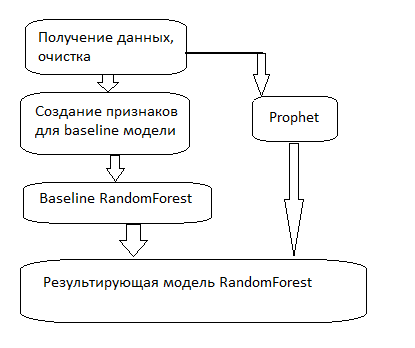